In [1]:
import pandas as pd
import pandas as pd
from collections import Counter
import re

In [5]:
df = pd.read_csv("C:/Project/RAG연구동향분석/250409/전체기간(1-7)/전체기간(1-7)상위10개군집노드.csv")
df.head()

C:\Users\eric0\AppData\Local\Temp\ipykernel_11300\1145236534.py:1: DtypeWarning: Columns (1,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:/Project/RAG연구동향분석/250409/전체기간(1-7)/전체기간(1-7)상위10개군집노드.csv")


,Id,Label,year,citations,research_fields,keywords,level,indegree,outdegree,Degree,modularity_class
0,53e9979bb7602d9701f66d44,Defeasible logic,2001.0,370.0,NaN,newspaper story warning | reasonable person | ...,L3,11,14,25,9
1,53e99808b7602d970201a746,Computing with shapes,2001.0,29.0,Data mining | Computer science | Polyomino | R...,computability model | turing machine | shape g...,L3,0,24,24,16
2,53e99a56b7602d97022bc23a,A truth maintenance system,1979.0,3043.0,Embedding | Course of action | Argument | Comp...,truth maintenance system | computer programmin...,L3,11,17,28,4
3,53e99e0cb7602d97026d141c,Microcomputer playfulness development of a mea...,1992.0,716.0,Knowledge management | Computer training | Psy...,workplace implication | microcomputer playfulness,L3,350,7,357,10
4,53e9a1b6b7602d9702aae9bb,Design Trade offs for Electronic Intermediaries,2008.0,4.0,Intermediary | Transparency graphic | Economic...,business network | intermediary | electronic c...,L3,0,13,13,6


In [6]:
# 1. 기간 정의 (period7 종료 연도 2022 확인)
if not df.empty and 'year' in df.columns:
    # 'year' 열 처리
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    df.dropna(subset=['year'], inplace=True)
    df['year'] = df['year'].astype(int)

    if not df.empty:
        min_year_full = df['year'].min()
        # max_year_full = df['year'].max() # 최대 연도 대신 2022 사용

        period_definitions = {
            'period1': {'start': min_year_full, 'end': 1999},
            'period2': {'start': 2000, 'end': 2003},
            'period3': {'start': 2004, 'end': 2007},
            'period4': {'start': 2008, 'end': 2011},
            'period5': {'start': 2012, 'end': 2015},
            'period6': {'start': 2016, 'end': 2019},
            'period7': {'start': 2020, 'end': 2022} # 기간 7은 2022년까지
        }
        defined_periods = set(period_definitions.keys())
        print("정의된 기간:", defined_periods)
        print("-" * 30)

        # 2. 기간 할당 함수 정의
        def assign_period(year):
            for period, definition in period_definitions.items():
                if definition['start'] <= year <= definition['end']:
                    return period
            return None # 2022년 이후 데이터는 특정 기간에 속하지 않음

        # 3. 'period' 열 생성 (df 사용)
        df['period'] = df['year'].apply(assign_period)

        # 4. 데이터에 실제 포함된 기간 확인 (df 사용)
        periods_in_data = set(df['period'].dropna().unique())
        print("데이터(df)에 포함된 기간:", periods_in_data)
        print("-" * 30)

        # 5. 모든 정의된 기간이 포함되어 있는지 확인
        missing_periods = defined_periods - periods_in_data
        if not missing_periods:
            print("결과: 정의된 모든 기간(period1 ~ period7)의 논문이 데이터(df)에 포함되어 있습니다.")
        else:
            print(f"결과: 다음 기간의 논문이 데이터(df)에 없습니다: {sorted(list(missing_periods))}")
            print("      (데이터의 연도 범위를 다시 확인하거나, 기간 정의가 올바른지 확인하세요.)")

        print("-" * 30)
        # 6. (참고) 실제 기간별 논문 수 출력 (df 사용)
        print("데이터(df) 내 실제 기간별 논문 수:")
        # 정의된 기간 순서 + None(미할당) 포함하여 출력
        period_order_check = list(period_definitions.keys())
        print(df['period'].value_counts(dropna=False).reindex(period_order_check + [None]))


    else:
        print("DataFrame(df)에 유효한 'year' 데이터가 없습니다.")

elif df.empty:
    print("DataFrame(df)이 비어 있거나 생성되지 않았습니다.")
else:
    print("DataFrame(df)에 'year' 컬럼을 찾을 수 없습니다.")

정의된 기간: {'period5', 'period1', 'period3', 'period4', 'period2', 'period6', 'period7'}
------------------------------
데이터(df)에 포함된 기간: {'period5', 'period1', 'period3', 'period4', 'period2', 'period6', 'period7'}
------------------------------
결과: 정의된 모든 기간(period1 ~ period7)의 논문이 데이터(df)에 포함되어 있습니다.
------------------------------
데이터(df) 내 실제 기간별 논문 수:
period
period1     4971.0
period2     5535.0
period3    10900.0
period4    15029.0
period5    15508.0
period6     9032.0
period7      792.0
None           NaN
Name: count, dtype: float64


In [7]:
# --- 사용자 설정: 실제 컬럼명으로 변경해주세요 ---
MODULARITY_COLUMN = 'modularity_class'
KEYWORDS_COLUMN = 'keywords'       # 키워드가 포함된 컬럼 이름
FIELDS_COLUMN = 'research_fields' # 원본 연구 분야 정보가 포함된 컬럼 이름
# ---------------------------------------------

# 1. 필요한 컬럼 존재 확인
required_cols = [MODULARITY_COLUMN, KEYWORDS_COLUMN, FIELDS_COLUMN]
if not all(col in df.columns for col in required_cols):
    print(f"오류: 필요한 컬럼 {required_cols} 중 일부가 DataFrame 'df'에 없습니다.")
    # 필요한 경우 여기서 코드 중단
else:
    # 'modularity_class' 정수형 변환 (필요시)
    df[MODULARITY_COLUMN] = pd.to_numeric(df[MODULARITY_COLUMN], errors='coerce').fillna(-1).astype(int)

    # 2. Modularity Class별 정보 집계 함수 정의 (이전과 동일)
    def get_top_terms(series, top_n=10, delimiter='|'):
        """Helper function to get top N terms from a series of delimited strings."""
        term_list = []
        # NaN 값을 빈 문자열로 처리하고 문자열로 변환
        series = series.fillna('').astype(str)
        for item in series:
            # 공백 제거 및 소문자 변환 후 분리
            terms = [term.strip().lower() for term in re.split(re.escape(delimiter), item) if term.strip()]
            term_list.extend(terms)
        # 빈도수 계산 및 상위 N개 추출
        return [term for term, count in Counter(term_list).most_common(top_n)]

    # 3. Modularity Class별 정보 집계 (df 직접 사용)
    if not df.empty:
        # fillna('')를 추가하여 NaN 값 처리
        grouped = df.groupby(MODULARITY_COLUMN).agg(
            node_count=('Id', 'count'), # 클래스별 노드 수 (기간 1~6 기준)
            top_keywords=(KEYWORDS_COLUMN, lambda x: get_top_terms(x.dropna(), top_n=10)), # 상위 키워드
            top_research_fields=(FIELDS_COLUMN, lambda x: get_top_terms(x.dropna(), top_n=5)) # 상위 연구 분야
        ).sort_values(by='node_count', ascending=False) # 노드 수 기준으로 정렬

        print("\n--- 기간 1~6 데이터 기준 Modularity Class별 정보 ---")
        print("(이 정보를 바탕으로 각 Class ID에 연구 분야 레이블을 부여하세요)")
        # 보기 좋게 출력하기 위해 DataFrame 표시 옵션 설정 (선택 사항)
        pd.set_option('display.max_rows', 200)
        pd.set_option('display.max_colwidth', 150)
        print(grouped)

        # 4. 도출된 주요 연구 분야 목록 (상위 N개 클래스)
        top_n_fields = 10 # 예시로 상위 10개
        major_classes = grouped.head(top_n_fields).index.tolist()
        print(f"\n기간 1~6 데이터에서 가장 많은 노드를 포함하는 상위 {top_n_fields}개 Modularity Class ID:")
        print(major_classes)
        print("\n(위 ID들에 대해 부여한 연구 분야 레이블이 주요 '주변 연구 분야'가 됩니다.)")

    else:
        print("DataFrame 'df'에 데이터가 없습니다.")



--- 기간 1~6 데이터 기준 Modularity Class별 정보 ---
(이 정보를 바탕으로 각 Class ID에 연구 분야 레이블을 부여하세요)
                  node_count  \
modularity_class               
10                     12077   
6                      11699   
58                      8389   
8                       6956   
9                       5312   
1                       4890   
4                       4397   
16                      3052   
12                      2548   
0                       2447   

                                                                                                                                                           top_keywords  \
modularity_class                                                                                                                                                          
10                [trust, information technology, technology acceptance model, internet, e commerce, electronic commerce, information system, information systems, t...   
6               

좋습니다! 아래는 **기간 1~6 데이터 기준 상위 10개 Modularity Class ID**에 대해, 각 클러스터의 `top_keywords`와 `top_research_fields`를 종합적으로 분석해 도출한 **연구 분야 영문 레이블 3안씩**입니다.

---

### ✅ Modularity Class별 연구 분야 레이블 (영문, 3안)

#### **Class 10**
- **Option 1**: Information Systems Adoption  
- **Option 2**: E-Commerce Trust Models  
- **Option 3**: Technology Acceptance Research  
> TAM 기반 수용 연구 + 전자상거래 신뢰 중심

---

#### **Class 6**
- **Option 1**: Enterprise IT Systems  
- **Option 2**: IT-Enabled Business Integration  
- **Option 3**: Information Systems Engineering  
> 정보시스템과 기업 아키텍처, 공급망 통합

---

#### **Class 58**
- **Option 1**: Knowledge Sharing Systems  
- **Option 2**: Collaborative Knowledge Management  
- **Option 3**: Groupware and CMC Studies  
> 지식관리, 협업 툴, 집단 커뮤니케이션 기술

---

#### **Class 8**
- **Option 1**: Software Engineering Practices  
- **Option 2**: Empirical Software Development  
- **Option 3**: IT Project Management  
> 소프트웨어 개발, 품질 및 프로젝트 관리

---

#### **Class 9**
- **Option 1**: Trust and Security Systems  
- **Option 2**: Reputation in Networks  
- **Option 3**: Distributed Trust Models  
> P2P 기반의 분산 신뢰 및 보안 메커니즘

---

#### **Class 1**
- **Option 1**: Recommender Systems Research  
- **Option 2**: Social Information Retrieval  
- **Option 3**: Personalized Web Intelligence  
> 추천 시스템 + 소셜 기반 정보 검색

---

#### **Class 4**
- **Option 1**: Business Process Modeling  
- **Option 2**: Enterprise Process Engineering  
- **Option 3**: Workflow Systems Design  
> 프로세스 모델링 및 업무 흐름 설계

---

#### **Class 16**
- **Option 1**: Human-Centered Computing  
- **Option 2**: Ubiquitous User Interfaces  
- **Option 3**: HCI in Smart Environments  
> HCI, 유비쿼터스, 사용자 경험 중심

---

#### **Class 12**
- **Option 1**: Cloud and Big Data  
- **Option 2**: Sustainable Computing Systems  
- **Option 3**: IoT and Green IT  
> 클라우드, IoT, 친환경 컴퓨팅 통합

---

#### **Class 0**
- **Option 1**: Machine Learning Applications  
- **Option 2**: Intelligent Data Mining  
- **Option 3**: Knowledge Discovery in AI  
> 분류, 규칙기반 학습, 데이터 마이닝

---

필요하시다면 이 레이블들을 JSON, CSV, DataFrame 등으로도 정리해드릴 수 있고, 시각화용 태그 생성이나 클러스터링 평가 지표 설정에도 활용 가능합니다.

In [8]:
# --- 사용자 설정 ---
MODULARITY_COLUMN = 'modularity_class' # 실제 modularity class 컬럼명
KEYWORDS_COLUMN = 'keywords'       # 키워드가 포함된 컬럼 이름 (필요시 사용)
FIELDS_COLUMN = 'research_fields' # 원본 연구 분야 정보 컬럼 이름 (필요시 사용)

# 새로운 상위 10개 클래스 ID 리스트
major_classes = [10, 6, 58, 8, 9, 1, 4, 16, 12, 0] # 새로운 ID로 업데이트!

chosen_labels = {
    # 아래 값들을 위 옵션 중 최종 선택한 것으로 수정하세요 (현재는 Option 1로 채워져 있음)
    10: "Information Systems Adoption",
    6:  "Enterprise IT Systems",
    58: "Knowledge Sharing Systems",
    8:  "Software Engineering Practices",
    9:  "Trust and Security Systems",
    1:  "Recommender Systems Research",
    4:  "Business Process Modeling",
    16: "Human-Centered Computing",
    12: "Cloud and Big Data",
    0:  "Machine Learning Applications"
}
# ---------------------------------------------------------------------

# 추적 대상 연구 분야 목록 (chosen_labels의 값들을 자동으로 사용)
fields_to_track = list(chosen_labels.values())

In [9]:
import pandas as pd
import io
from collections import Counter
import re

# 필요한 컬럼 및 타입 확인
required_cols_table = [MODULARITY_COLUMN, KEYWORDS_COLUMN, FIELDS_COLUMN]
if not all(col in df.columns for col in required_cols_table):
    print(f"오류: 필요한 컬럼 {required_cols_table} 중 일부가 DataFrame 'df'에 없습니다.")
else:
    # Modularity Class 정수형 변환
    df[MODULARITY_COLUMN] = pd.to_numeric(df[MODULARITY_COLUMN], errors='coerce').fillna(-1).astype(int)
    total_nodes_in_df = len(df) # 전체 네트워크의 노드 수 계산

    # 상위 10개 클래스에 대한 정보 저장 리스트
    results_list = []

    # 정보 집계 함수 (이전과 동일)
    def get_top_terms(series, top_n=10, delimiter='|'):
        term_list = []
        series = series.fillna('').astype(str)
        for item in series:
            terms = [term.strip().lower() for term in re.split(re.escape(delimiter), item) if term.strip()]
            term_list.extend(terms)
        return [term for term, count in Counter(term_list).most_common(top_n)]

    # 각 주요 클래스에 대해 정보 계산
    for class_id in major_classes:
        if class_id not in chosen_labels:
            print(f"경고: Modularity Class {class_id}에 대한 레이블이 chosen_labels에 없습니다. 건너<0xEB><0x9B><0x84>니다.")
            continue

        # 해당 클래스의 모든 노드 필터링 (전체 df 기준)
        df_cluster = df[df[MODULARITY_COLUMN] == class_id]

        if not df_cluster.empty:
            node_count_overall = len(df_cluster)
            ratio_overall = (node_count_overall / total_nodes_in_df) * 100 if total_nodes_in_df > 0 else 0
            # 전체 df 기준 상위 키워드 추출
            top_keywords_overall = get_top_terms(df_cluster[KEYWORDS_COLUMN].dropna(), top_n=10)
            # 선택된 연구 분야 레이블 가져오기
            research_field_label = chosen_labels[class_id]

            results_list.append({
                'Modularity Class': class_id,
                'Ratio (%)': ratio_overall,
                'Node Count': node_count_overall,
                'Keywords': top_keywords_overall, # 리스트 형태 유지
                'Research Field': research_field_label
            })
        else:
             print(f"정보: Modularity Class {class_id}에 속하는 노드가 전체 df에 없습니다.")

    # 비율(Ratio) 기준으로 결과 리스트 정렬
    if results_list:
        results_list.sort(key=lambda x: x['Ratio (%)'], reverse=True)

        print("\n--- 상위 10개 연구 분야 (Modularity Class) 정보 ---")
        # 정렬된 결과 출력
        for rank, result in enumerate(results_list, 1):
            print(f"\nRank {rank}:")
            print(f"  Modularity Class ID: {result['Modularity Class']}")
            print(f"  연구 분야 (Label): {result['Research Field']}")
            print(f"  비율 (Ratio): {result['Ratio (%)']:.2f}%") # 소수점 2자리
            print(f"  논문 수 (Node Count): {result['Node Count']}")
            print(f"  대표 키워드 (Top Keywords): {', '.join(result['Keywords'])}") # 콤마로 구분
            print("-" * 20)
    else:
        print("결과를 출력할 데이터가 없습니다.")


--- 상위 10개 연구 분야 (Modularity Class) 정보 ---

Rank 1:
  Modularity Class ID: 10
  연구 분야 (Label): Information Systems Adoption
  비율 (Ratio): 19.55%
  논문 수 (Node Count): 12077
  대표 키워드 (Top Keywords): trust, information technology, technology acceptance model, internet, e commerce, electronic commerce, information system, information systems, technology acceptance, adoption
--------------------

Rank 2:
  Modularity Class ID: 6
  연구 분야 (Label): Enterprise IT Systems
  비율 (Ratio): 18.94%
  논문 수 (Node Count): 11699
  대표 키워드 (Top Keywords): information technology, information system, information systems, electronic commerce, supply chain management, enterprise architecture, business process, e commerce, supply chain, business model
--------------------

Rank 3:
  Modularity Class ID: 58
  연구 분야 (Label): Knowledge Sharing Systems
  비율 (Ratio): 13.58%
  논문 수 (Node Count): 8389
  대표 키워드 (Top Keywords): knowledge management, knowledge sharing, information technology, knowledge management system,

--- 상위 10개 연구 분야 (Modularity Class) 정보 ---

Rank 1:
  Modularity Class ID: 10
  연구 분야 (Label): Information Systems Adoption
  비율 (Ratio): 19.55%
  논문 수 (Node Count): 12077
  대표 키워드 (Top Keywords): trust, information technology, technology acceptance model, internet, e commerce, electronic commerce, information system, information systems, technology acceptance, adoption
--------------------

Rank 2:
  Modularity Class ID: 6
  연구 분야 (Label): Enterprise IT Systems
  비율 (Ratio): 18.94%
  논문 수 (Node Count): 11699
  대표 키워드 (Top Keywords): information technology, information system, information systems, electronic commerce, supply chain management, enterprise architecture, business process, e commerce, supply chain, business model
--------------------

Rank 3:
  Modularity Class ID: 58
  연구 분야 (Label): Knowledge Sharing Systems
  비율 (Ratio): 13.58%
  논문 수 (Node Count): 8389
  대표 키워드 (Top Keywords): knowledge management, knowledge sharing, information technology, knowledge management system, computer mediated communication, groupware, collaboration, information system, knowledge transfer, innovation
--------------------

Rank 4:
  Modularity Class ID: 8
  연구 분야 (Label): Software Engineering Practices
  비율 (Ratio): 11.26%
  논문 수 (Node Count): 6956
  대표 키워드 (Top Keywords): software engineering, software development, project management, software quality, information technology, outsourcing, information system, empirical study, software maintenance, case study
--------------------

Rank 5:
  Modularity Class ID: 9
  연구 분야 (Label): Trust and Security Systems
  비율 (Ratio): 8.60%
  논문 수 (Node Count): 5312
  대표 키워드 (Top Keywords): trust, reputation, security, p2p, trust management, internet, quality of service, web services, web service, social network
--------------------

Rank 6:
  Modularity Class ID: 1
  연구 분야 (Label): Recommender Systems Research
  비율 (Ratio): 7.92%
  논문 수 (Node Count): 4890
  대표 키워드 (Top Keywords): information retrieval, recommender system, recommender systems, collaborative filtering, data mining, social media, internet, machine learning, sentiment analysis, text mining
--------------------

Rank 7:
  Modularity Class ID: 4
  연구 분야 (Label): Business Process Modeling
  비율 (Ratio): 7.12%
  논문 수 (Node Count): 4397
  대표 키워드 (Top Keywords): business process, business process management, process model, business process model, ontology, business process modeling, information system, process mining, conceptual model, software engineering
--------------------

Rank 8:
  Modularity Class ID: 16
  연구 분야 (Label): Human-Centered Computing
  비율 (Ratio): 4.94%
  논문 수 (Node Count): 3052
  대표 키워드 (Top Keywords): human computer interaction, human robot interaction, ubiquitous computing, health informatics, user interface, mobile computing, user experience, usability, design, health care
--------------------

Rank 9:
  Modularity Class ID: 12
  연구 분야 (Label): Cloud and Big Data
  비율 (Ratio): 4.13%
  논문 수 (Node Count): 2548
  대표 키워드 (Top Keywords): cloud computing, big data, internet of things, green it, sustainability, data mining, internet, information technology, software as a service, security
--------------------

Rank 10:
  Modularity Class ID: 0
  연구 분야 (Label): Machine Learning Applications
  비율 (Ratio): 3.96%
  논문 수 (Node Count): 2447
  대표 키워드 (Top Keywords): data mining, association rule, machine learning, knowledge discovery, neural network, classification, association rules, decision tree, clustering, neural networks
--------------------

---
---

In [10]:
def analyze_citations_from_df(df, period_name="기간"):
    """
    이미 불러온 DataFrame(df)에 대해 citations 총합과 평균을 계산하여 출력합니다.

    Parameters:
    - df (pd.DataFrame): 기간별 노드 데이터프레임
    - period_name (str): 출력용 기간 이름 (예: "기간 1")
    """
    if df.empty:
        print(f"[{period_name}] DataFrame이 비어 있습니다.")
        return

    if 'citations' not in df.columns:
        print(f"[{period_name}] 'citations' 컬럼이 존재하지 않습니다.")
        return

    try:
        df['citations'] = pd.to_numeric(df['citations'], errors='coerce')
        df = df.dropna(subset=['citations'])

        if df.empty:
            print(f"[{period_name}] 'citations'에 유효한 숫자 데이터가 없습니다.")
            return

        total_citations = df['citations'].sum()
        num_nodes = len(df)
        avg_citations = total_citations / num_nodes if num_nodes > 0 else 0

        print(f"\n📊 {period_name} 분석 결과:")
        print(f"- 노드 수: {num_nodes}")
        print(f"- 총 피인용수: {total_citations}")
        print(f"- 평균 피인용수: {avg_citations:.4f}")

    except Exception as e:
        print(f"[{period_name}] 계산 중 오류 발생: {e}")


In [11]:
df_period1_full = pd.read_csv("C:/Project/RAG연구동향분석/250409/p1/p1노드.csv")
df_period2_full = pd.read_csv("C:/Project/RAG연구동향분석/250409/p2(2000~2003)/p2노드.csv")
df_period3_full = pd.read_csv("C:/Project/RAG연구동향분석/250409/p3(2004~2007)/p3노드.csv")
df_period4_full = pd.read_csv("C:/Project/RAG연구동향분석/250409/p4(2008~2011)/p4노드.csv")
df_period5_full = pd.read_csv("C:/Project/RAG연구동향분석/250409/p5(2012~2015)/p5노드.csv")
df_period6_full = pd.read_csv("C:/Project/RAG연구동향분석/250409/p6(2016~2019)/p6노드.csv")

In [12]:
analyze_citations_from_df(df_period1_full, "기간 1")
analyze_citations_from_df(df_period2_full, "기간 2")
analyze_citations_from_df(df_period3_full, "기간 3")
analyze_citations_from_df(df_period4_full, "기간 4")
analyze_citations_from_df(df_period5_full, "기간 5")
analyze_citations_from_df(df_period6_full, "기간 6")


📊 기간 1 분석 결과:
- 노드 수: 4971
- 총 피인용수: 2872725
- 평균 피인용수: 577.8968

📊 기간 2 분석 결과:
- 노드 수: 5535
- 총 피인용수: 1772128
- 평균 피인용수: 320.1677

📊 기간 3 분석 결과:
- 노드 수: 10900
- 총 피인용수: 1702846
- 평균 피인용수: 156.2244

📊 기간 4 분석 결과:
- 노드 수: 15029
- 총 피인용수: 1538292
- 평균 피인용수: 102.3549

📊 기간 5 분석 결과:
- 노드 수: 15508
- 총 피인용수: 1141950
- 평균 피인용수: 73.6362

📊 기간 6 분석 결과:
- 노드 수: 9032
- 총 피인용수: 246071
- 평균 피인용수: 27.2444


---
---

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np # 순위 계산 시 NaN 처리를 위해 추가

In [14]:
try:
    # 사용 가능한 시스템 폰트 중 'NanumGothic' 이나 유사한 한글 폰트를 찾습니다.
    # 또는 직접 폰트 파일 경로를 지정합니다.
    font_path = fm.findfont('Malgun Gothic', fallback_to_default=False) # Windows 기본 '맑은 고딕'
    if not font_path:
        # '맑은 고딕'이 없을 경우, 다른 설치된 한글 폰트나 기본 폰트를 사용합니다.
        # 예: AppleGothic (macOS), NanumGothic (설치된 경우)
        font_name = fm.FontProperties(family='sans-serif').get_name()
        fm.fontManager.addfont(font_path) # 시스템에 폰트 추가가 필요할 수 있음
        plt.rc('font', family=font_name)
    else:
         plt.rc('font', family='Malgun Gothic')

except:
    print("한글 폰트를 찾을 수 없습니다. 기본 폰트로 그래프가 그려집니다. "
          "그래프에 한글이 깨질 수 있습니다. 한글 폰트를 설치하고 경로를 지정해주세요.")
    # 기본 sans-serif 폰트 사용
    plt.rc('font', family='sans-serif')

# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False    

데이터 로딩 완료.

--- 기간별 연구 분야 순위표 ---
                      Information Systems Adoption  \
Period                                               
Period 1 (..-1999)                             3.0   
Period 2 (2000-2003)                           3.0   
Period 3 (2004-2007)                           3.0   
Period 4 (2008-2011)                           3.0   
Period 5 (2012-2015)                           3.0   
Period 6 (2016-2019)                           3.0   

                      Enterprise Systems Integration  \
Period                                                 
Period 1 (..-1999)                               2.0   
Period 2 (2000-2003)                             1.0   
Period 3 (2004-2007)                             1.0   
Period 4 (2008-2011)                             1.0   
Period 5 (2012-2015)                             1.0   
Period 6 (2016-2019)                             1.0   

                      Cybersecurity and Privacy  Business Process Management  \
Peri

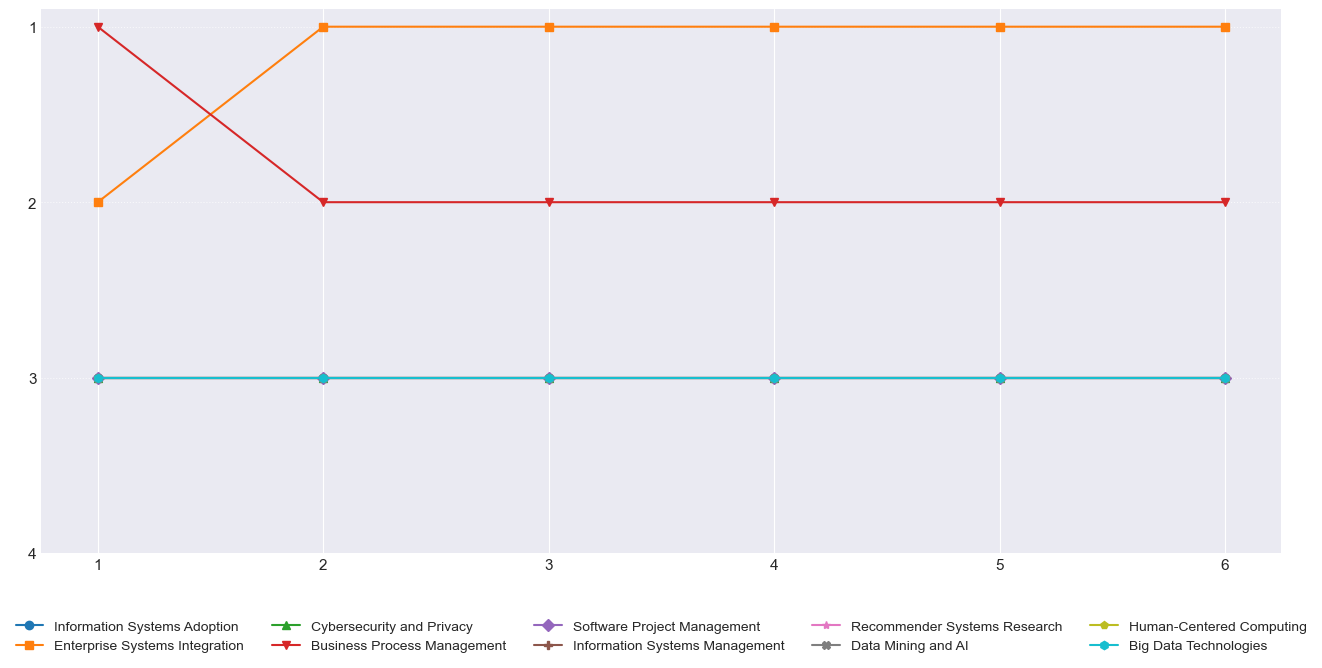

In [15]:
# <그림 4> 기간별(기간1 - 기간6) 주변 연구 분야의 비율 순위 변화

# --- 1. 데이터 로딩 ---
# (이전 코드와 동일)
try:
    df_period1_full = pd.read_csv("C:/Project/RAG연구동향분석/250409/p1/p1노드.csv")
    df_period2_full = pd.read_csv("C:/Project/RAG연구동향분석/250409/p2(2000~2003)/p2노드.csv")
    df_period3_full = pd.read_csv("C:/Project/RAG연구동향분석/250409/p3(2004~2007)/p3노드.csv")
    df_period4_full = pd.read_csv("C:/Project/RAG연구동향분석/250409/p4(2008~2011)/p4노드.csv")
    df_period5_full = pd.read_csv("C:/Project/RAG연구동향분석/250409/p5(2012~2015)/p5노드.csv")
    df_period6_full = pd.read_csv("C:/Project/RAG연구동향분석/250409/p6(2016~2019)/p6노드.csv")

    period_dfs_list = [
        ('Period 1 (..-1999)', df_period1_full),
        ('Period 2 (2000-2003)', df_period2_full),
        ('Period 3 (2004-2007)', df_period3_full),
        ('Period 4 (2008-2011)', df_period4_full),
        ('Period 5 (2012-2015)', df_period5_full),
        ('Period 6 (2016-2019)', df_period6_full)
    ]
    print("데이터 로딩 완료.")
except FileNotFoundError as e:
    print(f"파일 로딩 오류: {e}")
    period_dfs_list = []
except Exception as e:
    print(f"데이터 로딩 중 예상치 못한 오류 발생: {e}")
    period_dfs_list = []

# --- 2. 사용자 설정 ---
MODULARITY_COLUMN = 'modularity_class'

chosen_labels = {
    28: "Information Systems Adoption",
    9:  "Enterprise Systems Integration",
    39: "Cybersecurity and Privacy",
    16: "Business Process Management",
    3:  "Software Project Management",
    25: "Information Systems Management",
    18: "Recommender Systems Research",
    11: "Data Mining and AI",
    26: "Human-Centered Computing",
    17: "Big Data Technologies"
}

fields_to_track = list(chosen_labels.values())
# ---------------------------------------------------------------------

# --- 3. 기간별 연구 분야 비율 및 순위 계산 ---
period_results = {}
labels_to_class_id = {label: class_id for class_id, label in chosen_labels.items()}

if period_dfs_list and fields_to_track:
    for period_name, df_period in period_dfs_list:
        # (이전 코드와 동일한 계산 로직)
        if MODULARITY_COLUMN not in df_period.columns: continue
        df_period[MODULARITY_COLUMN] = pd.to_numeric(df_period[MODULARITY_COLUMN], errors='coerce').fillna(-1).astype(int)
        total_nodes_period = len(df_period)
        if total_nodes_period == 0:
            proportions = {field_label: np.nan for field_label in fields_to_track}
            period_results[period_name] = proportions
            continue
        class_counts_period = df_period[MODULARITY_COLUMN].value_counts()
        proportions = {}
        for field_label in fields_to_track:
            target_class_id = labels_to_class_id.get(field_label)
            if target_class_id is not None:
                count = class_counts_period.get(target_class_id, 0)
                proportion = (count / total_nodes_period) * 100 if total_nodes_period > 0 else 0
                proportions[field_label] = proportion
            else:
                proportions[field_label] = 0
        period_results[period_name] = proportions

    # 4. 비율 데이터를 DataFrame으로 변환하고 순위 계산
    if period_results:
        proportion_df = pd.DataFrame(period_results).T
        proportion_df.index.name = 'Period'
        rank_df = proportion_df.rank(axis=1, method='min', ascending=False, na_option='keep')
        print("\n--- 기간별 연구 분야 순위표 ---")
        print(rank_df) # 기본 출력

        # --- 5. 그래프 생성 (figsize 수정됨) ---
        try:
            font_path = fm.findfont('Malgun Gothic', fallback_to_default=False)
            if not font_path:
                font_name = fm.FontProperties(family='sans-serif').get_name()
                plt.rc('font', family=font_name)
                print(f"'{font_name}' 폰트 사용.")
            else:
                 plt.rc('font', family='Malgun Gothic')
                 print("'Malgun Gothic' 폰트 사용.")
        except Exception as e:
            print(f"폰트 설정 중 오류: {e}. 기본 폰트를 사용합니다.")
            plt.rc('font', family='sans-serif')
        plt.rcParams['axes.unicode_minus'] = False

        plt.style.use('seaborn-v0_8-darkgrid')
        # **** figsize의 가로 길이(첫 번째 값)를 늘림 (예: 12 -> 16) ****
        fig, ax = plt.subplots(figsize=(16, 8)) # 가로 길이를 16인치로 늘림

        colors = plt.cm.tab10(np.linspace(0, 1, 10))
        markers = ['o', 's', '^', 'v', 'D', 'P', '*', 'X', 'p', 'h']

        for i, field in enumerate(rank_df.columns):
            ax.plot(rank_df.index, rank_df[field], marker=markers[i % len(markers)],
                    color=colors[i % len(colors)], linestyle='-', linewidth=1.5, label=field)

        # 제목 및 축 레이블 제거됨 (이전 코드 유지)
        xtick_labels = [name.split(' ')[1] if '(' in name else name for name in rank_df.index]
        ax.set_xticks(rank_df.index)
        ax.set_xticklabels(xtick_labels, rotation=0, fontsize=11)
        plt.yticks(fontsize=11)
        ax.grid(axis='y', linestyle=':', alpha=0.7)

        # Y축 뒤집기 및 눈금 설정 (이전 코드 유지)
        ax.invert_yaxis()
        min_rank_val = 1
        max_rank_val = rank_df.max().max()
        if pd.notna(max_rank_val):
             ax.set_yticks(np.arange(min_rank_val, int(max_rank_val) + 2))
        else:
             ax.set_yticks(np.arange(1, len(fields_to_track) + 2))

        # 범례 하단 중앙 배치 (이전 코드 유지)
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                  ncol=5, fontsize=10) # ncol 값은 필요시 조절

        # 하단 여백 확보 (이전 코드 유지)
        fig.subplots_adjust(bottom=0.2)

        plt.show()

    else:
        print("\n오류: 비율 또는 순위 데이터를 생성하지 못했습니다.")

else:
    print("\n오류: 기간별 데이터프레임 로딩에 실패했거나 추적 대상 연구 분야 레이블이 정의되지 않았습니다.")

데이터 로딩 완료.

--- 기간별 연구 분야 순위표 ---
                      Information Systems Adoption  Enterprise IT Systems  \
Period                                                                      
Period 1 (..-1999)                            4.00                   1.00   
Period 2 (2000-2003)                          3.00                   1.00   
Period 3 (2004-2007)                          2.00                   1.00   
Period 4 (2008-2011)                          2.00                   1.00   
Period 5 (2012-2015)                          1.00                   2.00   
Period 6 (2016-2019)                          1.00                   2.00   

                      Knowledge Sharing Systems  \
Period                                            
Period 1 (..-1999)                         3.00   
Period 2 (2000-2003)                       2.00   
Period 3 (2004-2007)                       3.00   
Period 4 (2008-2011)                       3.00   
Period 5 (2012-2015)                       

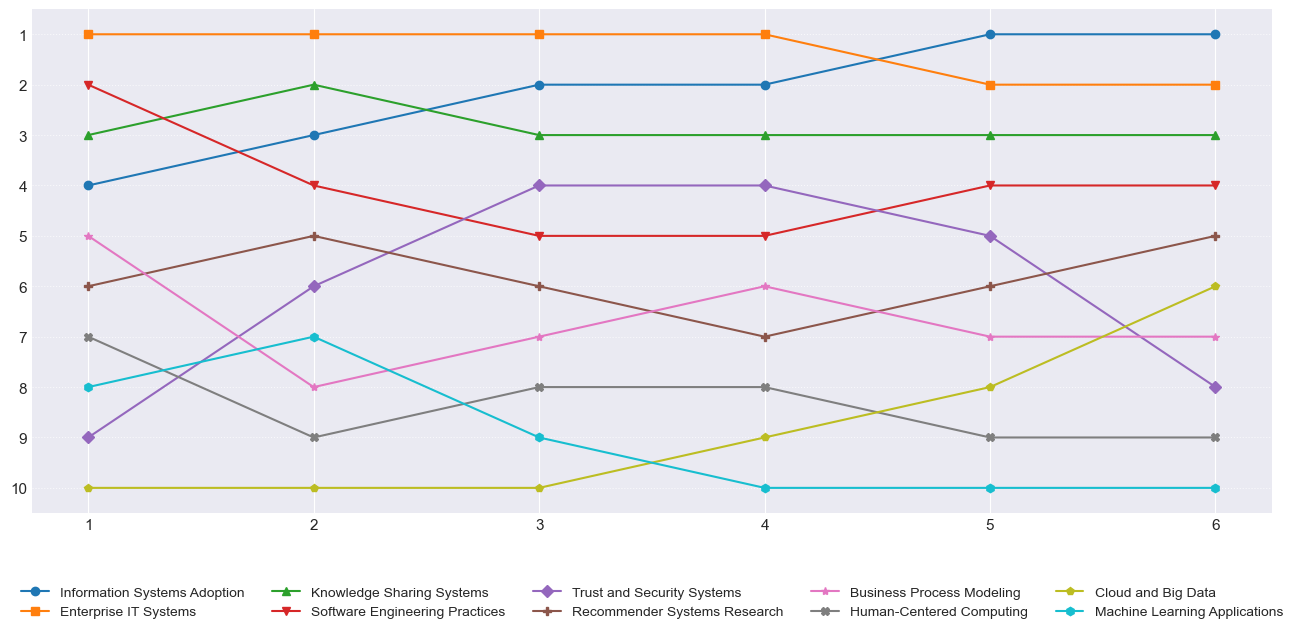

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

# --- 1. 데이터 로딩 ---
# 사용자가 제공한 경로를 사용합니다.
try:
    df_period1_full = pd.read_csv("C:/Project/RAG연구동향분석/250409/p1/p1노드.csv")
    df_period2_full = pd.read_csv("C:/Project/RAG연구동향분석/250409/p2(2000~2003)/p2노드.csv")
    df_period3_full = pd.read_csv("C:/Project/RAG연구동향분석/250409/p3(2004~2007)/p3노드.csv")
    df_period4_full = pd.read_csv("C:/Project/RAG연구동향분석/250409/p4(2008~2011)/p4노드.csv")
    df_period5_full = pd.read_csv("C:/Project/RAG연구동향분석/250409/p5(2012~2015)/p5노드.csv")
    df_period6_full = pd.read_csv("C:/Project/RAG연구동향분석/250409/p6(2016~2019)/p6노드.csv")

    period_dfs_list = [
        ('Period 1 (..-1999)', df_period1_full),
        ('Period 2 (2000-2003)', df_period2_full),
        ('Period 3 (2004-2007)', df_period3_full),
        ('Period 4 (2008-2011)', df_period4_full),
        ('Period 5 (2012-2015)', df_period5_full),
        ('Period 6 (2016-2019)', df_period6_full)
    ]
    print("데이터 로딩 완료.")
except FileNotFoundError as e:
    print(f"파일 로딩 오류: {e}")
    period_dfs_list = []
except Exception as e:
    print(f"데이터 로딩 중 예상치 못한 오류 발생: {e}")
    period_dfs_list = []

# --- 2. 사용자 설정 ---
MODULARITY_COLUMN = 'modularity_class'

# 사용자가 최종 정의한 연구 분야 레이블 사용
chosen_labels = {
    10: "Information Systems Adoption",
    6:  "Enterprise IT Systems",
    58: "Knowledge Sharing Systems",
    8:  "Software Engineering Practices",
    9:  "Trust and Security Systems",
    1:  "Recommender Systems Research",
    4:  "Business Process Modeling",
    16: "Human-Centered Computing",
    12: "Cloud and Big Data",
    0:  "Machine Learning Applications"
}

fields_to_track = list(chosen_labels.values())
# ---------------------------------------------------------------------

# --- 3. 기간별 연구 분야 비율 및 순위 계산 ---
period_results = {}
labels_to_class_id = {label: class_id for class_id, label in chosen_labels.items()}

if period_dfs_list and fields_to_track:
    for period_name, df_period in period_dfs_list:
        # (계산 로직은 이전과 동일)
        if MODULARITY_COLUMN not in df_period.columns:
            print(f"  경고: {MODULARITY_COLUMN} 컬럼이 {period_name}에 없습니다. 건너<0xEB><0x9B><0x84>니다.")
            proportions = {field_label: np.nan for field_label in fields_to_track}
            period_results[period_name] = proportions
            continue
        df_period[MODULARITY_COLUMN] = pd.to_numeric(df_period[MODULARITY_COLUMN], errors='coerce').fillna(-1).astype(int)
        total_nodes_period = len(df_period)
        if total_nodes_period == 0:
            proportions = {field_label: np.nan for field_label in fields_to_track}
            period_results[period_name] = proportions
            continue
        class_counts_period = df_period[MODULARITY_COLUMN].value_counts()
        proportions = {}
        for field_label in fields_to_track:
            target_class_id = labels_to_class_id.get(field_label)
            if target_class_id is not None:
                count = class_counts_period.get(target_class_id, 0)
                proportion = (count / total_nodes_period) * 100 if total_nodes_period > 0 else 0
                proportions[field_label] = proportion
            else:
                proportions[field_label] = 0
        period_results[period_name] = proportions

    # 4. 비율 데이터를 DataFrame으로 변환하고 순위 계산
    if period_results:
        proportion_df = pd.DataFrame(period_results).T
        proportion_df.index.name = 'Period'
        rank_df = proportion_df.rank(axis=1, method='min', ascending=False, na_option='keep')
        print("\n--- 기간별 연구 분야 순위표 ---")
        print(rank_df) # 순위표 출력 (필요시 주석 처리)

        # --- 5. 그래프 생성 (수정됨) ---
        try:
            # 한글 폰트 설정 (필요시 경로 수정)
            font_path = fm.findfont('Malgun Gothic', fallback_to_default=False)
            if not font_path:
                font_name = fm.FontProperties(family='sans-serif').get_name()
                plt.rc('font', family=font_name)
                print(f"'{font_name}' 폰트 사용.")
            else:
                 plt.rc('font', family='Malgun Gothic')
                 print("'Malgun Gothic' 폰트 사용.")
        except Exception as e:
            print(f"폰트 설정 중 오류: {e}. 기본 폰트를 사용합니다.")
            plt.rc('font', family='sans-serif')
        plt.rcParams['axes.unicode_minus'] = False

        plt.style.use('seaborn-v0_8-darkgrid')
        # **** figsize 가로 길이를 늘림 ****
        fig, ax = plt.subplots(figsize=(16, 8)) # 예: 가로 16, 세로 8

        # 색상/마커 설정
        # 10개 이상 필요 시 plt.cm.get_cmap('tab20') 등 다른 컬러맵 사용 가능
        num_fields = len(rank_df.columns)
        colors = plt.cm.tab10(np.linspace(0, 1, 10)) # 10개까지는 tab10 사용
        if num_fields > 10: # 10개 초과 시 다른 컬러맵이나 직접 지정 필요
             colors = plt.cm.get_cmap('tab20', num_fields)(np.linspace(0, 1, num_fields))
        markers = ['o', 's', '^', 'v', 'D', 'P', '*', 'X', 'p', 'h'] # 필요시 마커 추가

        # 라인 플롯
        if not rank_df.empty:
            for i, field in enumerate(rank_df.columns):
                ax.plot(rank_df.index, rank_df[field],
                        marker=markers[i % len(markers)],
                        color=colors[i % len(colors)], # 색상 순환 적용
                        linestyle='-',
                        linewidth=1.5,
                        label=field)

            # **** 제목 및 축 레이블 제거 ****
            # ax.set_title('기간별 연구 분야 순위 변화', fontsize=18, pad=15)
            # ax.set_xlabel('기간', fontsize=14)
            # ax.set_ylabel('순위 (Rank)', fontsize=14)

            # X축 눈금 레이블 설정
            xtick_labels = [name.split(' ')[1] if '(' in name else name for name in rank_df.index]
            ax.set_xticks(rank_df.index)
            ax.set_xticklabels(xtick_labels, rotation=0, fontsize=11)
            plt.yticks(fontsize=11)
            ax.grid(axis='y', linestyle=':', alpha=0.7)

            # Y축 뒤집기
            ax.invert_yaxis()

            # Y축 범위 및 눈금 설정
            min_rank_visible = 0.5
            max_rank_value_actual = rank_df.max().max()
            if pd.notna(max_rank_value_actual):
                max_rank_visible = max_rank_value_actual + 0.5
                # 정수 눈금 설정 (1부터 최대 랭크까지)
                ax.set_yticks(np.arange(1, int(max_rank_value_actual) + 1))
            else:
                max_rank_visible = len(fields_to_track) + 0.5 # 추적 분야 수 + 0.5
                ax.set_yticks(np.arange(1, len(fields_to_track) + 1)) # 1부터 추적 분야 수까지

            ax.set_ylim(max_rank_visible, min_rank_visible) # 최종 Y축 범위 설정


            # **** 범례 하단 중앙 배치 ****
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), # 위치 미세 조정 (-0.1 -> -0.12)
                      ncol=5, fontsize=10) # 예시: 5열

            # **** 하단 여백 확보 ****
            fig.subplots_adjust(bottom=0.25) # 여백 값 조정 (0.2 -> 0.25)

            plt.show()
        else:
            print("\n순위 데이터가 없어 그래프를 그릴 수 없습니다.")

    else:
        print("\n오류: 비율 또는 순위 데이터를 생성하지 못했습니다.")

else:
    print("\n오류: 기간별 데이터프레임 로딩에 실패했거나 추적 대상 연구 분야 레이블이 정의되지 않았습니다.")

In [21]:
import pandas as pd
import numpy as np

# --- 1. 데이터 로딩 ---
# (이전 코드와 동일 - 사용자가 제공한 경로 사용)
try:
    df_period1_full = pd.read_csv("C:/Project/RAG연구동향분석/250409/p1/p1노드.csv")
    df_period2_full = pd.read_csv("C:/Project/RAG연구동향분석/250409/p2(2000~2003)/p2노드.csv")
    df_period3_full = pd.read_csv("C:/Project/RAG연구동향분석/250409/p3(2004~2007)/p3노드.csv")
    df_period4_full = pd.read_csv("C:/Project/RAG연구동향분석/250409/p4(2008~2011)/p4노드.csv")
    df_period5_full = pd.read_csv("C:/Project/RAG연구동향분석/250409/p5(2012~2015)/p5노드.csv")
    df_period6_full = pd.read_csv("C:/Project/RAG연구동향분석/250409/p6(2016~2019)/p6노드.csv")

    period_dfs_list = [
        ('Period 1 (..-1999)', df_period1_full),
        ('Period 2 (2000-2003)', df_period2_full),
        ('Period 3 (2004-2007)', df_period3_full),
        ('Period 4 (2008-2011)', df_period4_full),
        ('Period 5 (2012-2015)', df_period5_full),
        ('Period 6 (2016-2019)', df_period6_full)
    ]
    print("데이터 로딩 완료.")
except FileNotFoundError as e:
    print(f"파일 로딩 오류: {e}")
    period_dfs_list = []
except Exception as e:
    print(f"데이터 로딩 중 예상치 못한 오류 발생: {e}")
    period_dfs_list = []

# --- 2. 사용자 설정 ---
MODULARITY_COLUMN = 'modularity_class' # 실제 modularity class 컬럼명

# 3. 기간별 연구 분야 비율 계산
period_proportions = {} # 결과를 저장할 딕셔너리

# 레이블을 키로, 클래스 ID를 값으로 하는 역방향 맵 생성
labels_to_class_id = {label: class_id for class_id, label in chosen_labels.items()}
print(f"\n계산 대상 연구 분야 ({len(fields_to_track)}개): {fields_to_track}")

# 데이터가 로드되었고 추적 대상이 있을 경우에만 진행
if period_dfs_list and fields_to_track:
    for period_name, df_period in period_dfs_list:
        print(f"\nProcessing {period_name}...")
        if MODULARITY_COLUMN not in df_period.columns:
            print(f"  오류: {MODULARITY_COLUMN} 컬럼이 {period_name} 데이터프레임에 없습니다. 건너<0xEB><0x9B><0x84>니다.")
            # 결과 딕셔너리에 빈 값 또는 NaN 채우기
            proportions_for_this_period = {field_label: np.nan for field_label in fields_to_track}
            period_proportions[period_name] = proportions_for_this_period
            continue

        # Modularity Class 컬럼 처리
        df_period[MODULARITY_COLUMN] = pd.to_numeric(df_period[MODULARITY_COLUMN], errors='coerce').fillna(-1).astype(int)

        total_nodes_period = len(df_period)
        if total_nodes_period == 0:
            print("  데이터 없음. 비율을 0 또는 NaN으로 기록합니다.")
            # 결과 딕셔너리에 빈 값 또는 NaN 채우기
            proportions_for_this_period = {field_label: np.nan for field_label in fields_to_track} # 또는 0.0
            period_proportions[period_name] = proportions_for_this_period
            continue

        # 해당 기간의 modularity_class 별 노드 수 계산
        class_counts_period = df_period[MODULARITY_COLUMN].value_counts()

        proportions_for_this_period = {}
        for field_label in fields_to_track:
            target_class_id = labels_to_class_id.get(field_label) # 역방향 맵에서 ID 조회
            proportion = 0.0 # 기본값 0
            if target_class_id is not None:
                count = class_counts_period.get(target_class_id, 0) # 해당 클래스 ID의 노드 수 (없으면 0)
                proportion = (count / total_nodes_period) * 100 # 비율(%) 계산
            else:
                 print(f"  경고: '{field_label}'에 매핑되는 Class ID가 chosen_labels에 없습니다. 비율 0으로 처리.")

            proportions_for_this_period[field_label] = proportion

        period_proportions[period_name] = proportions_for_this_period
        print(f"  {period_name} 비율 계산 완료.")

    # 4. 계산된 비율을 DataFrame으로 변환하여 출력
    if period_proportions:
        proportion_df = pd.DataFrame(period_proportions).T # 행: 기간, 열: 연구 분야, 값: 비율(%)
        proportion_df.index.name = 'Period'

        print("\n--- 기간별 연구 분야 비율 (%) ---")
        # 소수점 2자리까지 표시하도록 설정
        pd.set_option('display.float_format', '{:.2f}'.format)
        print(proportion_df.to_markdown(numalign="left", stralign="left"))

        # (선택 사항) 비율 높은 순서대로 컬럼 정렬하여 보기
        # print("\n--- 기간별 연구 분야 비율 (%) - 평균 비율 높은 순 정렬 ---")
        # print(proportion_df.sort_values(by=list(proportion_df.columns), axis=1, ascending=False))

        # 원래 float 표시 형식으로 복구 (필요시)
        # pd.reset_option('display.float_format')
    else:
        print("\n오류: 비율 데이터를 생성하지 못했습니다.")

else:
    print("\n오류: 기간별 데이터프레임 로딩에 실패했거나 추적 대상 연구 분야 레이블이 정의되지 않았습니다.")

데이터 로딩 완료.

계산 대상 연구 분야 (10개): ['Information Systems Adoption', 'Enterprise IT Systems', 'Knowledge Sharing Systems', 'Software Engineering Practices', 'Trust and Security Systems', 'Recommender Systems Research', 'Business Process Modeling', 'Human-Centered Computing', 'Cloud and Big Data', 'Machine Learning Applications']

Processing Period 1 (..-1999)...
  Period 1 (..-1999) 비율 계산 완료.

Processing Period 2 (2000-2003)...
  Period 2 (2000-2003) 비율 계산 완료.

Processing Period 3 (2004-2007)...
  Period 3 (2004-2007) 비율 계산 완료.

Processing Period 4 (2008-2011)...
  Period 4 (2008-2011) 비율 계산 완료.

Processing Period 5 (2012-2015)...
  Period 5 (2012-2015) 비율 계산 완료.

Processing Period 6 (2016-2019)...
  Period 6 (2016-2019) 비율 계산 완료.

--- 기간별 연구 분야 비율 (%) ---
| Period               | Information Systems Adoption   | Enterprise IT Systems   | Knowledge Sharing Systems   | Software Engineering Practices   | Trust and Security Systems   | Recommender Systems Research   | Business Process Modeling

데이터 로딩 완료.

계산 대상 연구 분야 (10개): ['Information Systems Adoption', 'Enterprise IT Systems', 'Knowledge Sharing Systems', 'Software Engineering Practices', 'Trust and Security Systems', 'Recommender Systems Research', 'Business Process Modeling', 'Human-Centered Computing', 'Cloud and Big Data', 'Machine Learning Applications']

Processing Period 1 (..-1999)...
  Period 1 (..-1999) 비율 계산 완료.

Processing Period 2 (2000-2003)...
  Period 2 (2000-2003) 비율 계산 완료.

Processing Period 3 (2004-2007)...
  Period 3 (2004-2007) 비율 계산 완료.

Processing Period 4 (2008-2011)...
  Period 4 (2008-2011) 비율 계산 완료.

Processing Period 5 (2012-2015)...
  Period 5 (2012-2015) 비율 계산 완료.

Processing Period 6 (2016-2019)...
  Period 6 (2016-2019) 비율 계산 완료.

--- 기간별 연구 분야 비율 (%) ---
| Period               | Information Systems Adoption   | Enterprise IT Systems   | Knowledge Sharing Systems   | Software Engineering Practices   | Trust and Security Systems   | Recommender Systems Research   | Business Process Modeling   | Human-Centered Computing   | Cloud and Big Data   | Machine Learning Applications   |
|:---------------------|:-------------------------------|:------------------------|:----------------------------|:---------------------------------|:-----------------------------|:-------------------------------|:----------------------------|:---------------------------|:---------------------|:--------------------------------|
| Period 1 (..-1999)   | 10.7423                        | 23.1543                 | 13.9409                     | 17.1796                          | 1.99155                      | 8.5697                         | 9.75659                     | 7.66445                    | 0.4828               | 6.5178                          |
| Period 2 (2000-2003) | 15.935                         | 22.1138                 | 16.2421                     | 11.7977                          | 7.06414                      | 9.01536                        | 6.28726                     | 4.73351                    | 0.451671             | 6.35953                         |
| Period 3 (2004-2007) | 16.9358                        | 20.0826                 | 15.9817                     | 11.4495                          | 11.6055                      | 7.29358                        | 7.26606                     | 4.54128                    | 0.770642             | 4.07339                         |
| Period 4 (2008-2011) | 18.604                         | 18.8635                 | 14.1726                     | 10.8856                          | 11.3447                      | 6.80684                        | 7.63857                     | 4.93047                    | 3.65959              | 3.09402                         |
| Period 5 (2012-2015) | 23.0268                        | 17.6876                 | 12.1357                     | 10.0335                          | 8.2667                       | 7.75729                        | 6.77715                     | 4.97163                    | 6.40315              | 2.94042                         |
| Period 6 (2016-2019) | 24.9336                        | 15.6887                 | 10.9942                     | 10.0089                          | 5.89017                      | 9.42205                        | 5.94553                     | 4.16298                    | 8.9349               | 4.01904                         |